In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import torch.nn.functional as F
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_files = {
    'leftImg8bit': '/content/drive/MyDrive/dataset/leftImg8bit_trainvaltest.zip',
    'gtFine': '/content/drive/MyDrive/dataset/gtFine_trainvaltest.zip'
}

extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

def extract_zip(zip_path, extract_to):
    if not os.path.isfile(zip_path):
        print(f"Error: File {zip_path} does not exist.")
        return False
    if not zip_path.endswith('.zip'):
        print(f"Error: File {zip_path} is not a zip file.")
        return False

    try:
        shutil.unpack_archive(zip_path, extract_to)
        print(f"Successfully extracted {zip_path} to {extract_to}")
        return True
    except shutil.ReadError as e:
        print(f"Error extracting {zip_path}: {e}")
        return False


for name, zip_path in zip_files.items():
    extract_zip(zip_path, extract_dir)


Successfully extracted /content/drive/MyDrive/dataset/leftImg8bit_trainvaltest.zip to /content/dataset
Successfully extracted /content/drive/MyDrive/dataset/gtFine_trainvaltest.zip to /content/dataset


In [4]:
!ls /content/dataset/leftImg8bit_trainvaltest
!ls /content/dataset/gtFine_trainvaltest


leftImg8bit  license.txt  README
gtFine	license.txt  README


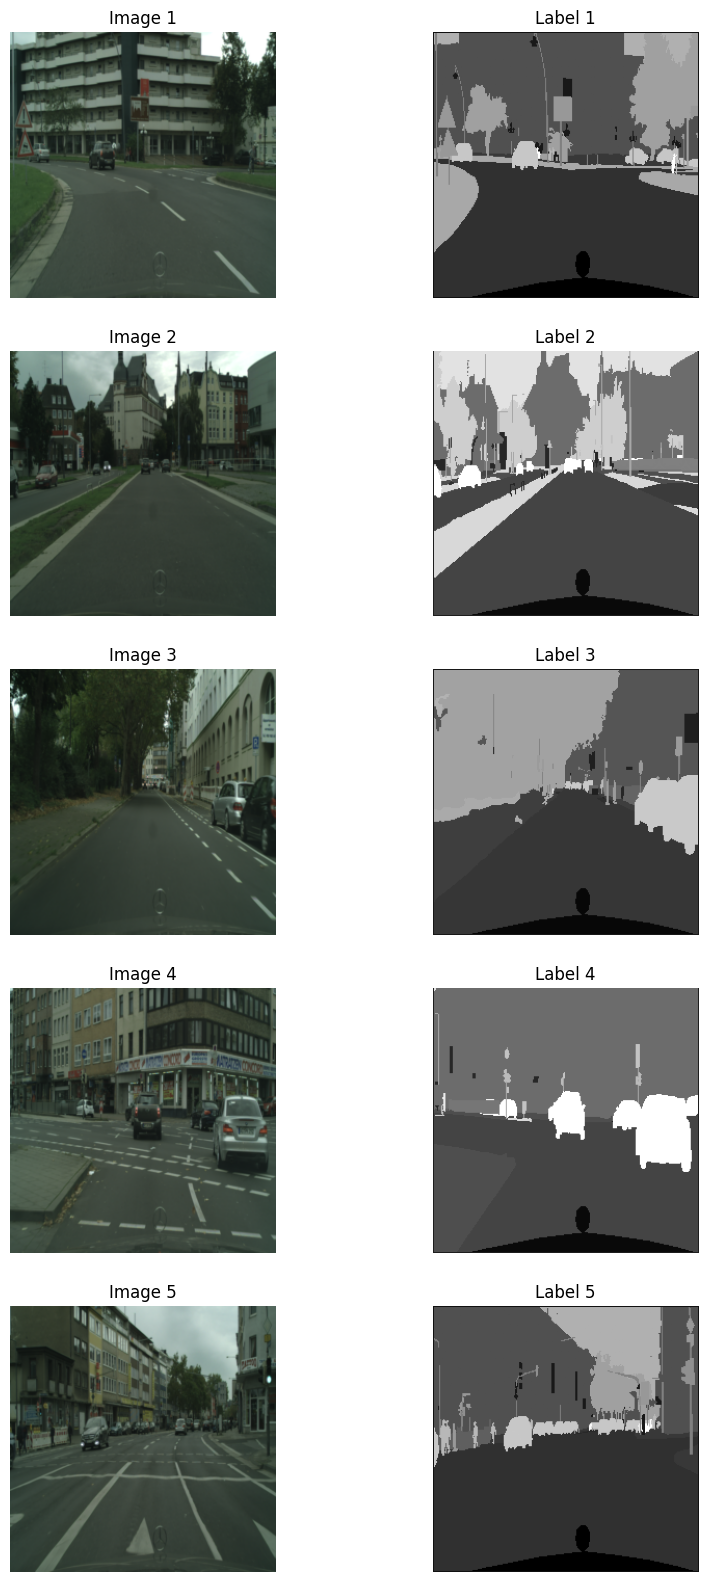

In [5]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, label_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.label_transform = label_transform

        image_pattern = os.path.join(root_dir, 'leftImg8bit_trainvaltest/leftImg8bit', split, '*', '*.png')
        label_pattern = os.path.join(root_dir, 'gtFine_trainvaltest/gtFine', split, '*', '*_labelIds.png')

        self.images = sorted(glob.glob(image_pattern))
        self.labels = sorted(glob.glob(label_pattern))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = Image.open(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])


root_dir = '/content/dataset/'
train_dataset = CityscapesDataset(
    root_dir=root_dir,
    split='train',
    transform=image_transform,
    label_transform=label_transform
)
val_dataset = CityscapesDataset(
    root_dir=root_dir,
    split='val',
    transform=image_transform,
    label_transform=label_transform
)

def show_images_and_labels(dataset, num_images=5):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 20))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        image = image.numpy()

        label = label.squeeze(0).numpy()

        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Image {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label, cmap='gray')
        axs[i, 1].set_title(f'Label {i+1}')
        axs[i, 1].axis('off')

    plt.show()


show_images_and_labels(train_dataset, num_images=5)


In [6]:
class InitialBlock(nn.Module):
    def __init__(self):
        super(InitialBlock, self).__init__()
        self.conv = nn.Conv2d(3, 13, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.prelu = nn.PReLU(16)

    def forward(self, x):
        main = self.conv(x)
        side = F.max_pool2d(x, kernel_size=2, stride=2)
        out = torch.cat((main, side), dim=1)
        out = self.bn(out)
        return self.prelu(out)

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, asymmetric, dropout_prob):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu1 = nn.PReLU(out_channels)

        if asymmetric:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (kernel_size, 1), stride=stride, padding=(padding, 0), dilation=dilation, bias=False),
                nn.Conv2d(out_channels, out_channels, (1, kernel_size), stride=stride, padding=(0, padding), dilation=dilation, bias=False)
            )
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.prelu2 = nn.PReLU(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.prelu3 = nn.PReLU(out_channels)

        self.dropout = nn.Dropout2d(p=dropout_prob)

    def forward(self, x):
        main = self.conv1(x)
        main = self.bn1(main)
        main = self.prelu1(main)

        main = self.conv2(main)
        main = self.bn2(main)
        main = self.prelu2(main)

        main = self.conv3(main)
        main = self.bn3(main)
        main = self.prelu3(main)

        return self.dropout(main)

class DownsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsamplingBottleneck, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels - in_channels, kernel_size=2, stride=2, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU(out_channels)
        self.pad_channels = out_channels - in_channels

    def forward(self, x):
        main = self.pool(x)
        pad = self.conv(x)
        if self.pad_channels > 0:
            main = torch.cat((main, pad), dim=1)
        main = self.bn(main)
        return self.prelu(main)

class UpsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsamplingBottleneck, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU(out_channels)

    def forward(self, x):
        main = self.conv(x)
        main = self.bn(main)
        return self.prelu(main)

class ENet(nn.Module):
    def __init__(self, num_classes):
        super(ENet, self).__init__()
        self.initial_block = InitialBlock()

        self.bottleneck1_0 = DownsamplingBottleneck(16, 64)
        self.bottleneck1_1 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.01)
        self.bottleneck1_2 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.01)
        self.bottleneck1_3 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.01)
        self.bottleneck1_4 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.01)

        self.bottleneck2_0 = DownsamplingBottleneck(64, 128)
        self.bottleneck2_1 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)
        self.bottleneck2_2 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=2, dilation=2, asymmetric=False, dropout_prob=0.1)
        self.bottleneck2_3 = Bottleneck(128, 128, kernel_size=5, stride=1, padding=2, dilation=1, asymmetric=True, dropout_prob=0.1)
        self.bottleneck2_4 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=4, dilation=4, asymmetric=False, dropout_prob=0.1)
        self.bottleneck2_5 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)
        self.bottleneck2_6 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=8, dilation=8, asymmetric=False, dropout_prob=0.1)
        self.bottleneck2_7 = Bottleneck(128, 128, kernel_size=5, stride=1, padding=2, dilation=1, asymmetric=True, dropout_prob=0.1)
        self.bottleneck2_8 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=16, dilation=16, asymmetric=False, dropout_prob=0.1)

        self.bottleneck3_1 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)
        self.bottleneck3_2 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=2, dilation=2, asymmetric=False, dropout_prob=0.1)
        self.bottleneck3_3 = Bottleneck(128, 128, kernel_size=5, stride=1, padding=2, dilation=1, asymmetric=True, dropout_prob=0.1)
        self.bottleneck3_4 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=4, dilation=4, asymmetric=False, dropout_prob=0.1)
        self.bottleneck3_5 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)
        self.bottleneck3_6 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=8, dilation=8, asymmetric=False, dropout_prob=0.1)
        self.bottleneck3_7 = Bottleneck(128, 128, kernel_size=5, stride=1, padding=2, dilation=1, asymmetric=True, dropout_prob=0.1)
        self.bottleneck3_8 = Bottleneck(128, 128, kernel_size=3, stride=1, padding=16, dilation=16, asymmetric=False, dropout_prob=0.1)

        self.bottleneck4_0 = UpsamplingBottleneck(128, 64)
        self.bottleneck4_1 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)
        self.bottleneck4_2 = Bottleneck(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)

        self.bottleneck5_0 = UpsamplingBottleneck(64, 16)
        self.bottleneck5_1 = Bottleneck(16, 16, kernel_size=3, stride=1, padding=1, dilation=1, asymmetric=False, dropout_prob=0.1)

        self.fullconv = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):

        x = self.initial_block(x)

        x = self.bottleneck1_0(x)
        x = self.bottleneck1_1(x)
        x = self.bottleneck1_2(x)
        x = self.bottleneck1_3(x)
        x = self.bottleneck1_4(x)

        x = self.bottleneck2_0(x)
        x = self.bottleneck2_1(x)
        x = self.bottleneck2_2(x)
        x = self.bottleneck2_3(x)
        x = self.bottleneck2_4(x)
        x = self.bottleneck2_5(x)
        x = self.bottleneck2_6(x)
        x = self.bottleneck2_7(x)
        x = self.bottleneck2_8(x)

        x = self.bottleneck3_1(x)
        x = self.bottleneck3_2(x)
        x = self.bottleneck3_3(x)
        x = self.bottleneck3_4(x)
        x = self.bottleneck3_5(x)
        x = self.bottleneck3_6(x)
        x = self.bottleneck3_7(x)
        x = self.bottleneck3_8(x)

        x = self.bottleneck4_0(x)
        x = self.bottleneck4_1(x)
        x = self.bottleneck4_2(x)

        x = self.bottleneck5_0(x)
        x = self.bottleneck5_1(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.fullconv(x)
        return x

In [9]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

def dice_coefficient(pred, target, smooth=1):
    pred = torch.argmax(pred, dim=1)
    target = target
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice


def simple_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        union = (pred_inds | target_inds).sum().float().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    mean_iou = np.nanmean(ious)
    return mean_iou


def class_to_rgb(mask, num_classes):
    np.random.seed(0)
    colormap = np.random.randint(0, 255, (num_classes, 3), dtype=np.uint8)
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for cls in range(num_classes):
        mask_rgb[mask == cls] = colormap[cls]

    return mask_rgb

def save_image(tensor, path, num_classes):
    tensor = tensor.cpu().clone()
    tensor = torch.argmax(tensor, dim=0).byte().numpy()
    mask_rgb = class_to_rgb(tensor, num_classes)
    image = Image.fromarray(mask_rgb)
    image.save(path)

Training Epoch 1: 100%|██████████| 372/372 [02:31<00:00,  2.46it/s]


Epoch 1/50, Training Loss: 2.4766


Validation Epoch 1: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 1/50, Validation Loss: 2.2231


Training Epoch 2: 100%|██████████| 372/372 [02:31<00:00,  2.45it/s]


Epoch 2/50, Training Loss: 1.9706


Validation Epoch 2: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 2/50, Validation Loss: 1.6685


Training Epoch 3: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 3/50, Training Loss: 1.3661


Validation Epoch 3: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 3/50, Validation Loss: 1.0248


Training Epoch 4: 100%|██████████| 372/372 [02:31<00:00,  2.45it/s]


Epoch 4/50, Training Loss: 0.8358


Validation Epoch 4: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 4/50, Validation Loss: 0.6173


Training Epoch 5: 100%|██████████| 372/372 [02:33<00:00,  2.43it/s]


Epoch 5/50, Training Loss: 0.4923


Validation Epoch 5: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 5/50, Validation Loss: 0.3538


Training Epoch 6: 100%|██████████| 372/372 [02:33<00:00,  2.42it/s]


Epoch 6/50, Training Loss: 0.2915


Validation Epoch 6: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 6/50, Validation Loss: 0.1952


Training Epoch 7: 100%|██████████| 372/372 [02:31<00:00,  2.45it/s]


Epoch 7/50, Training Loss: 0.1822


Validation Epoch 7: 100%|██████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch 7/50, Validation Loss: 0.1258


Training Epoch 8: 100%|██████████| 372/372 [02:32<00:00,  2.44it/s]


Epoch 8/50, Training Loss: 0.1157


Validation Epoch 8: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 8/50, Validation Loss: 0.0789


Training Epoch 9: 100%|██████████| 372/372 [02:33<00:00,  2.42it/s]


Epoch 9/50, Training Loss: 0.0786


Validation Epoch 9: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 9/50, Validation Loss: 0.0536


Training Epoch 10: 100%|██████████| 372/372 [02:34<00:00,  2.40it/s]


Epoch 10/50, Training Loss: 0.0545


Validation Epoch 10: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 10/50, Validation Loss: 0.0357


Training Epoch 11: 100%|██████████| 372/372 [02:32<00:00,  2.44it/s]


Epoch 11/50, Training Loss: 0.0395


Validation Epoch 11: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 11/50, Validation Loss: 0.0221


Training Epoch 12: 100%|██████████| 372/372 [02:32<00:00,  2.45it/s]


Epoch 12/50, Training Loss: 0.0288


Validation Epoch 12: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch 12/50, Validation Loss: 0.0177


Training Epoch 13: 100%|██████████| 372/372 [02:35<00:00,  2.39it/s]


Epoch 13/50, Training Loss: 0.0213


Validation Epoch 13: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 13/50, Validation Loss: 0.0131


Training Epoch 14: 100%|██████████| 372/372 [02:32<00:00,  2.44it/s]


Epoch 14/50, Training Loss: 0.0161


Validation Epoch 14: 100%|██████████| 63/63 [00:26<00:00,  2.37it/s]


Epoch 14/50, Validation Loss: 0.0101


Training Epoch 15: 100%|██████████| 372/372 [02:35<00:00,  2.40it/s]


Epoch 15/50, Training Loss: 0.0121


Validation Epoch 15: 100%|██████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 15/50, Validation Loss: 0.0072


Training Epoch 16: 100%|██████████| 372/372 [02:34<00:00,  2.40it/s]


Epoch 16/50, Training Loss: 0.0091


Validation Epoch 16: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 16/50, Validation Loss: 0.0056


Training Epoch 17: 100%|██████████| 372/372 [02:34<00:00,  2.41it/s]


Epoch 17/50, Training Loss: 0.0073


Validation Epoch 17: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 17/50, Validation Loss: 0.0043


Training Epoch 18: 100%|██████████| 372/372 [02:33<00:00,  2.43it/s]


Epoch 18/50, Training Loss: 0.0056


Validation Epoch 18: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 18/50, Validation Loss: 0.0028


Training Epoch 19: 100%|██████████| 372/372 [02:33<00:00,  2.42it/s]


Epoch 19/50, Training Loss: 0.0046


Validation Epoch 19: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 19/50, Validation Loss: 0.0024


Training Epoch 20: 100%|██████████| 372/372 [02:33<00:00,  2.42it/s]


Epoch 20/50, Training Loss: 0.0035


Validation Epoch 20: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 20/50, Validation Loss: 0.0019


Training Epoch 21: 100%|██████████| 372/372 [02:34<00:00,  2.41it/s]


Epoch 21/50, Training Loss: 0.0027


Validation Epoch 21: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 21/50, Validation Loss: 0.0014


Training Epoch 22: 100%|██████████| 372/372 [02:32<00:00,  2.44it/s]


Epoch 22/50, Training Loss: 0.0022


Validation Epoch 22: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 22/50, Validation Loss: 0.0011


Training Epoch 23: 100%|██████████| 372/372 [02:33<00:00,  2.42it/s]


Epoch 23/50, Training Loss: 0.0017


Validation Epoch 23: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 23/50, Validation Loss: 0.0009


Training Epoch 24: 100%|██████████| 372/372 [02:34<00:00,  2.41it/s]


Epoch 24/50, Training Loss: 0.0014


Validation Epoch 24: 100%|██████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 24/50, Validation Loss: 0.0007


Training Epoch 25: 100%|██████████| 372/372 [02:32<00:00,  2.44it/s]


Epoch 25/50, Training Loss: 0.0011


Validation Epoch 25: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 25/50, Validation Loss: 0.0005


Training Epoch 26: 100%|██████████| 372/372 [02:33<00:00,  2.43it/s]


Epoch 26/50, Training Loss: 0.0009


Validation Epoch 26: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 26/50, Validation Loss: 0.0004


Training Epoch 27: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 27/50, Training Loss: 0.0007


Validation Epoch 27: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 27/50, Validation Loss: 0.0003


Training Epoch 28: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 28/50, Training Loss: 0.0006


Validation Epoch 28: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 28/50, Validation Loss: 0.0002


Training Epoch 29: 100%|██████████| 372/372 [02:30<00:00,  2.48it/s]


Epoch 29/50, Training Loss: 0.0005


Validation Epoch 29: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 29/50, Validation Loss: 0.0002


Training Epoch 30: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 30/50, Training Loss: 0.0004


Validation Epoch 30: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 30/50, Validation Loss: 0.0002


Training Epoch 31: 100%|██████████| 372/372 [02:28<00:00,  2.50it/s]


Epoch 31/50, Training Loss: 0.0003


Validation Epoch 31: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 31/50, Validation Loss: 0.0001


Training Epoch 32: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 32/50, Training Loss: 0.0003


Validation Epoch 32: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 32/50, Validation Loss: 0.0001


Training Epoch 33: 100%|██████████| 372/372 [02:31<00:00,  2.46it/s]


Epoch 33/50, Training Loss: 0.0002


Validation Epoch 33: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 33/50, Validation Loss: 0.0001


Training Epoch 34: 100%|██████████| 372/372 [02:29<00:00,  2.48it/s]


Epoch 34/50, Training Loss: 0.0002


Validation Epoch 34: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 34/50, Validation Loss: 0.0001


Training Epoch 35: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 35/50, Training Loss: 0.0001


Validation Epoch 35: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 35/50, Validation Loss: 0.0001


Training Epoch 36: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 36/50, Training Loss: 0.0001


Validation Epoch 36: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 36/50, Validation Loss: 0.0000


Training Epoch 37: 100%|██████████| 372/372 [02:30<00:00,  2.46it/s]


Epoch 37/50, Training Loss: 0.0001


Validation Epoch 37: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 37/50, Validation Loss: 0.0000


Training Epoch 38: 100%|██████████| 372/372 [02:30<00:00,  2.48it/s]


Epoch 38/50, Training Loss: 0.0001


Validation Epoch 38: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 38/50, Validation Loss: 0.0000


Training Epoch 39: 100%|██████████| 372/372 [02:29<00:00,  2.48it/s]


Epoch 39/50, Training Loss: 0.0001


Validation Epoch 39: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 39/50, Validation Loss: 0.0000


Training Epoch 40: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 40/50, Training Loss: 0.0000


Validation Epoch 40: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 40/50, Validation Loss: 0.0000


Training Epoch 41: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 41/50, Training Loss: 0.0000


Validation Epoch 41: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 41/50, Validation Loss: 0.0000


Training Epoch 42: 100%|██████████| 372/372 [02:30<00:00,  2.48it/s]


Epoch 42/50, Training Loss: 0.0000


Validation Epoch 42: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 42/50, Validation Loss: 0.0000


Training Epoch 43: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 43/50, Training Loss: 0.0000


Validation Epoch 43: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


Epoch 43/50, Validation Loss: 0.0000


Training Epoch 44: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 44/50, Training Loss: 0.0000


Validation Epoch 44: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 44/50, Validation Loss: 0.0000


Training Epoch 45: 100%|██████████| 372/372 [02:29<00:00,  2.49it/s]


Epoch 45/50, Training Loss: 0.0000


Validation Epoch 45: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch 45/50, Validation Loss: 0.0000


Training Epoch 46: 100%|██████████| 372/372 [02:30<00:00,  2.46it/s]


Epoch 46/50, Training Loss: 0.0000


Validation Epoch 46: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 46/50, Validation Loss: 0.0000


Training Epoch 47: 100%|██████████| 372/372 [02:31<00:00,  2.46it/s]


Epoch 47/50, Training Loss: 0.0000


Validation Epoch 47: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 47/50, Validation Loss: 0.0000


Training Epoch 48: 100%|██████████| 372/372 [02:31<00:00,  2.46it/s]


Epoch 48/50, Training Loss: 0.0000


Validation Epoch 48: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 48/50, Validation Loss: 0.0000


Training Epoch 49: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 49/50, Training Loss: 0.0000


Validation Epoch 49: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 49/50, Validation Loss: 0.0000


Training Epoch 50: 100%|██████████| 372/372 [02:30<00:00,  2.47it/s]


Epoch 50/50, Training Loss: 0.0000


Validation Epoch 50: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 50/50, Validation Loss: 0.0000


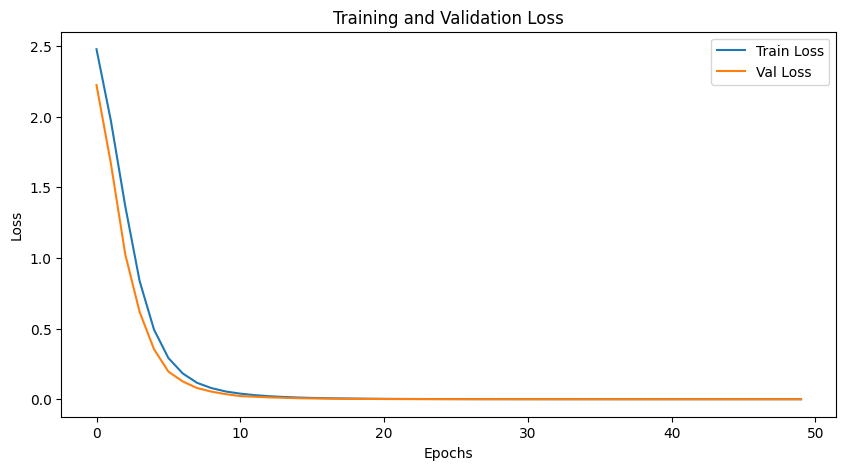

In [11]:
def train_model():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scaler = torch.cuda.amp.GradScaler()

    num_epochs = 50
    num_classes = 30
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []
    dice_scores = []
    ious = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1).long()

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        dice_score = 0.0
        mean_iou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}'):
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.squeeze(1).long()

                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                dice_score += dice_coefficient(outputs, labels).item() * images.size(0)
                mean_iou += simple_iou(outputs, labels, num_classes) * images.size(0)

        val_loss /= len(val_loader.dataset)
        dice_score /= len(val_loader.dataset)
        mean_iou /= len(val_loader.dataset)

        val_losses.append(val_loss)
        dice_scores.append(dice_score)
        ious.append(mean_iou)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch == num_epochs - 1:
            os.makedirs('final_images_', exist_ok=True)
            for i in range(min(len(images), 5)):
                save_image(images[i], f'final_images_/final_image_{i}.png', num_classes=3)
                save_image(outputs[i], f'final_images_/final_output_{i}.png', num_classes=19)

    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('loss_plot.png')

num_classes = 19
model = ENet(num_classes)
train_model()
